In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_train = pd.read_csv('/tmp/ANTM.JK.csv')
data_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-29,432.588074,436.787964,407.388763,432.588074,304.904572,7.618067e+07
1,2005-09-30,457.787384,457.787384,432.588074,457.787384,322.666016,1.054940e+08
2,2005-10-03,470.387024,474.586914,440.987854,470.387024,331.546692,5.971296e+07
3,2005-10-04,474.586914,482.986694,466.187164,474.586914,334.506927,5.623667e+07
4,2005-10-05,482.986694,482.986694,466.187164,482.986694,340.427429,3.131932e+07
...,...,...,...,...,...,...,...
3803,2021-01-28,2470.000000,2570.000000,2380.000000,2380.000000,2380.000000,7.318549e+08
3804,2021-01-29,2370.000000,2440.000000,2220.000000,2220.000000,2220.000000,4.503212e+08
3805,2021-02-01,2090.000000,2640.000000,2070.000000,2600.000000,2600.000000,2.186653e+09
3806,2021-02-02,2600.000000,2630.000000,2420.000000,2420.000000,2420.000000,9.424343e+08


In [3]:
data_train.isnull().sum(axis = 0)

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Text(0.5, 1.0, 'Open Price of ANTM')

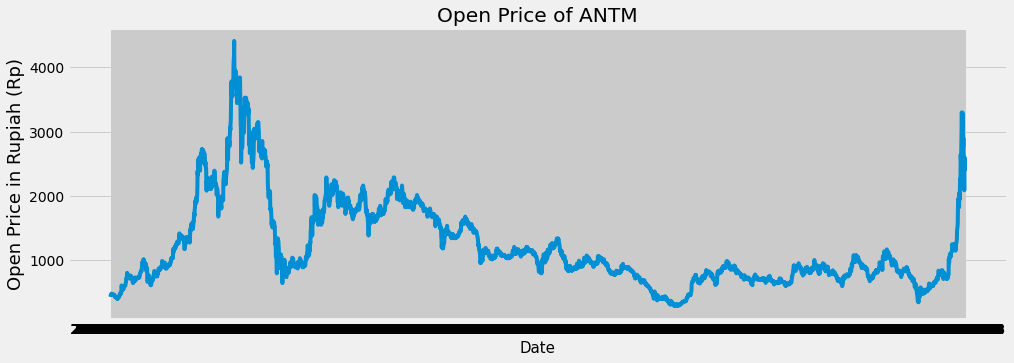

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

date = data_train['Date'].values
open  = data_train['Open'].values

rolling_mean20 = data_train['Open'].rolling(window=20).mean()
rolling_mean50 = data_train['Open'].rolling(window=50).mean()
rolling_mean200 = data_train['Open'].rolling(window=200).mean()

plt.figure(figsize=(15,5))
plt.plot(date, open)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Open Price in Rupiah (Rp)', fontsize = 18)
plt.title('Open Price of ANTM')

In [7]:
from sklearn.model_selection import train_test_split
dates_train, date_test, open_train, open_test = train_test_split(date, open, test_size=0.2, random_state=0, shuffle=False)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
import numpy as np
open = open.astype(np.int32)

In [10]:
data_train.shape

(3808, 7)

In [11]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

max_features = 20000 
maxlen = 200

inputs = keras.Input(shape=(None,), dtype="int32")
review = layers.Embedding(max_features, 128)(inputs)
review = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(review)
review = layers.Bidirectional(layers.LSTM(64))(review)
outputs = layers.Dense(1, activation="sigmoid")(review)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [22]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

(date_train, open_train), (date_val, open_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)
date_train = keras.preprocessing.sequence.pad_sequences(date_train, maxlen=maxlen)
date_val = keras.preprocessing.sequence.pad_sequences(date_val, maxlen=maxlen)
print(len(date_train), "Training sequences")
print(len(date_val), "Validation sequences")

25000 Training sequences
25000 Validation sequences


In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 25)
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.98)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [24]:
history = model.fit(date_train, open_train, batch_size=100, epochs=2, validation_data=(date_val, open_val))

Epoch 1/2
250/250 [==============================] - 330s 1s/step - loss: 0.1250 - mae: 0.5000 - val_loss: 0.1250 - val_mae: 0.5000
Epoch 2/2
250/250 [==============================] - 327s 1s/step - loss: 0.1250 - mae: 0.5000 - val_loss: 0.1250 - val_mae: 0.5000
